# ¿Cuál es un mejor plan?

## Índice <a id='back'></a>
* [Introducción](#intro)
* [Etapa 1. Descripción y preprocesamiento de los datos](#data_review)
    * [1.1. Planes](#data_review_plans)
    * [1.2. Usuarios](#data_review_users)
    * [1.3. Llamadas](#data_review_calls)
    * [1.4. Mensajes](#data_review_messages)
    * [1.5. Internet](#data_review_internet)
    * [1.6. Conclusiones](#data_review_conclusion)
* [Etapa 2. Preparación de los datos](#data_prep)
    * [2.1. Tarifa por usuario](#data_prep_income)
* [Etapa 3. Análisis exploratorio de datos](#data_analysis)
    * [3.1. Llamadas](#data_analysis_calls)
    * [3.2. Mensajes](#data_analysis_messages)
    * [3.3. Internet](#data_analysis_mb)
    * [3.4. Ingreso](#data_analysis_income)
    * [3.4. Conclusiones](#data_analysis_conclusions)
* [Etapa 4. Comprobación de hipótesis](#data_hypothesis)
    * [4.1. El ingreso difiere por plan](#data_hypothesis_plan)
    * [4.2. El ingreso difiere por región](#data_hypothesis_zone)
* [Etapa 5. Conclusión general](#data_conclusion)

## Introducción <a id='intro'></a>

Este proyecto es realizado para el operador de telecomunicaciones Megaline, el cual ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. Para ello se cuentan con los datos de 500 clientes incluidos la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018.

**Objetivo e Hipótesis**

El objetivo es determinar cuál de los planes genera más ingresos para ajustar el presupuesto de publicidad. Se establecen dos hipótesis:
1. El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.
2. El ingreso promedio de los usuarios en el área de estados Nueva York - Nueva Jersey es diferente al de los usuarios de otras regiones.

**Etapas**
Los datos se almacenan en los archivos:
- `/datasets/megaline_calls.csv`
- `/datasets/megaline_internet.csv`
- `/datasets/megaline_messages.csv`
- `/datasets/megaline_plans.csv`
- `/datasets/megaline_users.csv`

No hay ninguna información sobre la calidad de los datos así que se examinarán antes de probar las hipótesis.

Primero, se evaluará la calidad de los datos y si los problemas son significativos, entonces, durante el preprocesamiento de datos, se tomará en cuenta los problemas más críticos. Finalmente se comprobarán las hipótesis para presentar las conclusiones.
 
El proyecto consistirá en cinco etapas:
 1. Descripción y preprocesamiento de los datos.
 2. Preparación de los datos.
 3. Análisis exploratorio de los datos.
 4. Comprobación de hipótesis.
 5. Conclusión general.

[Volver a Contenidos](#back)

## Etapa 1. Descripción y preprocesamiento de los datos <a id='data_review'></a>

Se importan las librerías necesarias.

In [1]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from math import ceil, factorial

Debido a que son cinco archivos se creará un diccionario que contenga estos DataFrames.

In [2]:
# Carga los archivos de datos en diferentes DataFrames
df = {}
df_names = ['calls', 'internet', 'messages', 'plans', 'users']
df_csv = ['megaline_calls.csv', 'megaline_internet.csv', 'megaline_messages.csv', 'megaline_plans.csv', 'megaline_users.csv']
df_path = ['/datasets/megaline_calls.csv', '/datasets/megaline_internet.csv', '/datasets/megaline_messages.csv',
           '/datasets/megaline_plans.csv', '/datasets/megaline_users.csv']

for i in range(0,5):
    try:
        df[df_names[i]] = pd.read_csv(df_csv[i])
    except:
        df[df_names[i]] = pd.read_csv(df_path[i])

[Volver a Contenidos](#back)

### 1. 1. Planes <a id='data_review_plans'></a>

Megaline redondea los segundos a minutos y los megabytes a gigabytes. Cada **llamada individual** se redondea al minuto siguiente, incluso si duró sólo un segundo. Las **sesiones web individuales** no se redondea, se contabiliza por mes y se redondea al gigabyte siguiente.

Los planes consisten en lo siguiente:

**Surf**
1. Pago mensual: \$20.
2. 500 minutos al mes, 50 SMS y 15 GB de datos.
3. Si se exceden los límites del paquete:
    * 1 minuto: 3 centavos.
    * 1 SMS: 3 centavos.
    * 1 GB de datos: \$10.

**Ultimate**
1. Pago mensual: \$70.
2. 3000 minutos al mes, 1,000 SMS y 30 GB de datos.
3. Si se exceden los límites del paquete:
    * 1 minuto: 1 centavo.
    * 1 SMS: 1 centavo.
    * 1 GB de datos: \$7.

Se mostrará la tabla de los planes y su información general.

In [3]:
# Información general sobre el DataFrame de los planes
df['plans'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [4]:
# Datos para los planes
print(df['plans'])

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute plan_name  
0               20          10             0.03            0.03      surf  
1               70           7             0.01            0.01  ultimate  


Este DataFrame contiene la información de los planes desglosada en 8 columnas, las cuales son:
1. `messages_included` - SMS incluidos por mes.
2. `mb_per_month_included` - datos incluidos por mes (en megabytes, 1 GB = 1,024 MB).
3. `minutes_included` - minutos incluidos por mes.
4. `usd_monthly_pay` - pago mensual en dólares estadounidenses.
5. `usd_per_gb` - precio por gigabyte de los datos extra tras exceder los límites del plan.
6. `usd_per_message` - precio por SMS tras exceder los límites del plan.
7. `usd_per_minute` - precio por minuto tras exceder los límites del plan.
8. `plan_name` - nombre del plan.

No existen datos ausentes ni duplicados. Se procede con el siguiente DataFrame.

[Volver a Contenidos](#back)

### 1. 2. Usuarios <a id='data_review_users'></a>

El siguiente DataFrame muestra información sobre los 500 usuarios. Se mostrará la información general y las primeras 10 filas de dicha tabla.

In [5]:
# Información general/resumen sobre el DataFrame de los usuarios
df['users'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [6]:
print(df['users'].head(10))

   user_id first_name  last_name  age                                    city  \
0     1000   Anamaria      Bauer   45   Atlanta-Sandy Springs-Roswell, GA MSA   
1     1001     Mickey  Wilkerson   28         Seattle-Tacoma-Bellevue, WA MSA   
2     1002     Carlee    Hoffman   36    Las Vegas-Henderson-Paradise, NV MSA   
3     1003   Reynaldo    Jenkins   52                           Tulsa, OK MSA   
4     1004    Leonila   Thompson   40         Seattle-Tacoma-Bellevue, WA MSA   
5     1005      Livia    Shields   31     Dallas-Fort Worth-Arlington, TX MSA   
6     1006     Jesusa   Bradford   73  San Francisco-Oakland-Berkeley, CA MSA   
7     1007    Eusebio      Welch   42           Grand Rapids-Kentwood, MI MSA   
8     1008      Emely    Hoffman   53       Orlando-Kissimmee-Sanford, FL MSA   
9     1009      Gerry     Little   19  San Jose-Sunnyvale-Santa Clara, CA MSA   

     reg_date      plan  churn_date  
0  2018-12-24  ultimate         NaN  
1  2018-08-13      surf         

Este DataFrame tiene 8 columnas, las cuales son:
1. `user_id` - identificador único de usuario.
2. `firs_name` - nombre del usuario.
3. `last_name` - apellido del usuario.
4. `age` - edad del usuario (en años).
5. `city` - ciudad de residencia del usuario.
6. `reg_date` - fecha de suscripción (aaaa-mm-dd).
7. `plan` - nombre del plan contratado.
8. `churn_date` - fecha en la que el usuario dejó de usar el servicio (si el valor es ausente, la tarifa se estaba usando cuando se recuperaron los datos).

Debido al identificador único de usuario es sencillo determinar si existen duplicados obvios. Se mostrará la cantidad de filas duplicadas.

In [7]:
print(df['users'].duplicated().sum())

0


No existen filas duplicadas. La única columna con valores ausentes es `churn_date` y esto es debido a que los usuarios estaban suscritos cuando se recuperaron los datos. Se imprimirá la cantidad de valores en esta columna.

In [8]:
print(df['users']['churn_date'].value_counts())

2018-12-18    3
2018-11-14    2
2018-12-31    2
2018-12-19    2
2018-11-16    1
2018-12-15    1
2018-08-16    1
2018-12-30    1
2018-12-10    1
2018-11-21    1
2018-08-19    1
2018-11-18    1
2018-12-27    1
2018-11-30    1
2018-09-07    1
2018-09-01    1
2018-10-07    1
2018-12-26    1
2018-12-22    1
2018-10-22    1
2018-11-29    1
2018-12-12    1
2018-09-17    1
2018-11-24    1
2018-09-18    1
2018-11-11    1
2018-10-03    1
2018-07-31    1
2018-10-13    1
Name: churn_date, dtype: int64


Como se había mencionado todas las fechas son del año 2018. Se dedice mantener los valores ausentes de esta columna para indicar que son usuarios aún suscritos al plan (además no se trabajará con los valores de esta columna).

Se cambiará el formato de fecha para las columnas `'reg_date'` y `'churn_date'`.

In [9]:
df['users']['reg_date'] = pd.to_datetime(df['users']['reg_date'], format='%Y-%m-%d')
df['users']['churn_date'] = pd.to_datetime(df['users']['churn_date'], format='%Y-%m-%d')
df['users'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Finalmente, se determinará si existen duplicados ímplicitos en la columna `'city'`.

In [10]:
print(df['users']['city'].sort_values().unique())

['Albany-Schenectady-Troy, NY MSA' 'Albuquerque, NM MSA'
 'Atlanta-Sandy Springs-Roswell, GA MSA'
 'Austin-Round Rock-Georgetown, TX MSA' 'Bakersfield, CA MSA'
 'Baltimore-Columbia-Towson, MD MSA' 'Baton Rouge, LA MSA'
 'Birmingham-Hoover, AL MSA' 'Boston-Cambridge-Newton, MA-NH MSA'
 'Bridgeport-Stamford-Norwalk, CT MSA' 'Buffalo-Cheektowaga, NY MSA'
 'Cape Coral-Fort Myers, FL MSA' 'Charleston-North Charleston, SC MSA'
 'Charlotte-Concord-Gastonia, NC-SC MSA'
 'Chicago-Naperville-Elgin, IL-IN-WI MSA' 'Cincinnati, OH-KY-IN MSA'
 'Cleveland-Elyria, OH MSA' 'Colorado Springs, CO MSA' 'Columbia, SC MSA'
 'Columbus, OH MSA' 'Dallas-Fort Worth-Arlington, TX MSA'
 'Dayton-Kettering, OH MSA' 'Denver-Aurora-Lakewood, CO MSA'
 'Detroit-Warren-Dearborn, MI MSA' 'El Paso, TX MSA' 'Fresno, CA MSA'
 'Grand Rapids-Kentwood, MI MSA' 'Greensboro-High Point, NC MSA'
 'Houston-The Woodlands-Sugar Land, TX MSA'
 'Indianapolis-Carmel-Anderson, IN MSA' 'Jacksonville, FL MSA'
 'Kansas City, MO-KS MSA' 'Kno

No existen duplicados ímplicitos. Se procede con el siguiente DataFrame.

[Volver a Contenidos](#back)

### 1. 3. Llamadas <a id='data_review_calls'></a>

El siguiente DataFrame muestra información sobre las llamadas realizadas por los usuarios. Se mostrará la información general y las primeras 10 filas de dicha tabla.

In [11]:
# Iformación/resumen general sobre el DataFrame de las llamadas
df['calls'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [12]:
# Imprime una muestra de datos para llamadas
print(df['calls'].head(10))

         id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
5  1000_388     1000  2018-12-31      2.20
6  1000_510     1000  2018-12-27      5.75
7  1000_521     1000  2018-12-28     14.18
8  1000_530     1000  2018-12-28      5.77
9  1000_544     1000  2018-12-26      4.40


Con la información general se observa que no existen valores ausentes. El DataFrame contiene 4 columnas, las cuales son:
1. `id` - identificador único de llamada.
2. `user_id` - identificador del usuario que realizó la llamada.
3. `call_date` - fecha de la llamada.
4. `duration` - duración de la llamada (en minutos).

Debido al identificador único de llamada es sencillo determinar si existen duplicados obvios. Se mostrará la cantidad de filas duplicadas.

In [13]:
print(df['calls'].duplicated().sum())

0


No existen filas duplicadas. Se cambiará el formato de fecha de la columna `'call_date'`.

In [14]:
df['calls']['call_date'] = pd.to_datetime(df['calls']['call_date'], format='%Y-%m-%d')
df['calls'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


Para la siguiente etapa (análisis exploratorio de datos) se determinará la cantidad de llamadas y su duración por período mensual, por lo que se determinará el mes al que pertenece la fecha de la llamada. Se agregará la columna `'month'` la cual tendrá el mes del año en el que se realizó la llamada.

In [15]:
df['calls']['month'] = pd.DatetimeIndex(df['calls']['call_date']).month
print(df['calls'].head(10))

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27      8.52     12
1  1000_145     1000 2018-12-27     13.66     12
2  1000_247     1000 2018-12-27     14.48     12
3  1000_309     1000 2018-12-28      5.76     12
4  1000_380     1000 2018-12-30      4.22     12
5  1000_388     1000 2018-12-31      2.20     12
6  1000_510     1000 2018-12-27      5.75     12
7  1000_521     1000 2018-12-28     14.18     12
8  1000_530     1000 2018-12-28      5.77     12
9  1000_544     1000 2018-12-26      4.40     12


Como Megaline redondea cada llamada individual al minuto siguiente incluso si duró sólo un segundo, entonces se redondearán al minuto siguiente los datos de la columna `'duration'`.

In [16]:
df['calls']['duration'] = df['calls']['duration'].apply(ceil)
print(df['calls'].head(10))

         id  user_id  call_date  duration  month
0   1000_93     1000 2018-12-27         9     12
1  1000_145     1000 2018-12-27        14     12
2  1000_247     1000 2018-12-27        15     12
3  1000_309     1000 2018-12-28         6     12
4  1000_380     1000 2018-12-30         5     12
5  1000_388     1000 2018-12-31         3     12
6  1000_510     1000 2018-12-27         6     12
7  1000_521     1000 2018-12-28        15     12
8  1000_530     1000 2018-12-28         6     12
9  1000_544     1000 2018-12-26         5     12


Cabe la posibilidad que existan llamadas de duración 0, se mostrará la cantidad y su porcentaje.

In [17]:
missed_calls = len(df['calls'][df['calls']['duration'] == 0])
conv_missed_calls = missed_calls / len(df['calls'])
print(f'Existen {missed_calls} llamadas de 0 segundos, esto representa el {conv_missed_calls:.0%}')

Existen 26834 llamadas de 0 segundos, esto representa el 19%


La razón de la existencia de llamadas de 0 segundos puede ser que pertenezcan a llamadas perdidas. Se observa que es un porcentaje considerable por lo que se decide conservar dichas filas. Además, los planes de Megaline contabilizan las llamadas por minutos y no por cantidad. Por lo tanto, estas filas aportarán información sobre actividad aunque no afecten en la tarifa del plan.

Se muestra nuevamente la información general de este DataFrame tras los últimos cambios.

In [18]:
df['calls'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
 4   month      137735 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 5.3+ MB


Se procede a investigar el siguiente DataFrame.

[Volver a Contenidos](#back)

### 1. 4. Mensajes <a id='data_review_messages'></a>

El siguiente DataFrame muestra información sobre los mensajes enviados por los usuarios. Se mostrará la información general y las primeras 10 filas de dicha tabla.

In [19]:
# Información/resumen general sobre el DataFrame de los mensajes
df['messages'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [20]:
print(df['messages'].head(10))

         id  user_id message_date
0  1000_125     1000   2018-12-27
1  1000_160     1000   2018-12-31
2  1000_223     1000   2018-12-31
3  1000_251     1000   2018-12-27
4  1000_255     1000   2018-12-26
5  1000_346     1000   2018-12-29
6  1000_386     1000   2018-12-30
7  1000_413     1000   2018-12-31
8  1000_502     1000   2018-12-27
9  1000_525     1000   2018-12-28


Con la información general se observa que no existen datos ausentes. La tabla contiene 3 columnas, las cuales son:
1. `id` - identificador único del SMS.
2. `user_id` - identificador del usuario que envió el SMS.
3. `message_date` - fecha en la que se envió el SMS.

Debido al identificador único de SMS es sencillo determinar si existen duplicados obvios. Se mostrará la cantidad de filas duplicadas.

In [21]:
print(df['messages'].duplicated().sum())

0


No existen filas duplicadas. Se cambiará el formato de fecha en la columna `'message_date'`. 

In [22]:
df['messages']['message_date'] = pd.to_datetime(df['messages']['message_date'], format='%Y-%m-%d')
df['messages'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


Como en el DataFrame anterior, se agregará la columna `'month'` la cual tendrá el mes del año en el que se envió el SMS.

In [23]:
df['messages']['month'] = pd.DatetimeIndex(df['messages']['message_date']).month
print(df['messages'].head(10))

         id  user_id message_date  month
0  1000_125     1000   2018-12-27     12
1  1000_160     1000   2018-12-31     12
2  1000_223     1000   2018-12-31     12
3  1000_251     1000   2018-12-27     12
4  1000_255     1000   2018-12-26     12
5  1000_346     1000   2018-12-29     12
6  1000_386     1000   2018-12-30     12
7  1000_413     1000   2018-12-31     12
8  1000_502     1000   2018-12-27     12
9  1000_525     1000   2018-12-28     12


Finalmente, se muestra la información general del DataFrame tras los últimos cambios.

In [24]:
df['messages'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.3+ MB


[Volver a Contenidos](#back)

### 1. 5. Internet <a id='data_review_internet'></a>

El siguiente DataFrame muestra información sobre los megabytes utilizados por los usuarios. Se mostrará la información general y las primeras 10 filas de dicha tabla.

In [25]:
# Información/resumen general sobre el DataFrame del internet
df['internet'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [26]:
print(df['internet'].head(10))

         id  user_id session_date  mb_used
0   1000_13     1000   2018-12-29    89.86
1  1000_204     1000   2018-12-31     0.00
2  1000_379     1000   2018-12-28   660.40
3  1000_413     1000   2018-12-26   270.99
4  1000_442     1000   2018-12-27   880.22
5    1001_0     1001   2018-08-24   284.68
6    1001_3     1001   2018-12-09   656.04
7    1001_4     1001   2018-11-04    16.97
8   1001_10     1001   2018-11-27   135.18
9   1001_15     1001   2018-12-13   761.92


Con la información general se observa que no existen datos ausentes. La tabla contiene 4 columnas, las cuales son:
1. `id` - identificador único de la sesión.
2. `user_id` - identificador del usuario.
3. `session_date` - fecha en la que se utilizaron los megabytes.
4. `mb_used` - cantidad de datos gastados durante la sesión (en megabytes).

Debido al identificador único de la sesión es sencillo determinar si existen duplicados obvios. Se mostrará la cantidad de filas duplicadas.

In [27]:
print(df['internet'].duplicated().sum())

0


No existen filas duplicadas. También se puede observar que hay sesiones de 0 megabytes, esto puede deberse a que el usuario abrió algún navegador por equivocación. Como los planes de Megaline contabilizan el tráfico de internet por el total de megabytes utilizados durante el mes, entonces estas filas no afectarán el costo de la tarifa mensual pero si mostrarán información sobre actividad del usuario. Se decide conservar estas filas al igual que con las llamadas de 0 segundos.

Se cambiará el formato de fecha en la columna `'session_date'`. 

In [28]:
df['internet']['session_date'] = pd.to_datetime(df['internet']['session_date'], format='%Y-%m-%d')
df['internet'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


Como en los DataFrames anteriores, se agregará la columna `'month'` la cual tendrá el día del año en el que se utilizaron los megabytes.

In [29]:
df['internet']['month'] = pd.DatetimeIndex(df['internet']['session_date']).month
print(df['internet'].head(10))

         id  user_id session_date  mb_used  month
0   1000_13     1000   2018-12-29    89.86     12
1  1000_204     1000   2018-12-31     0.00     12
2  1000_379     1000   2018-12-28   660.40     12
3  1000_413     1000   2018-12-26   270.99     12
4  1000_442     1000   2018-12-27   880.22     12
5    1001_0     1001   2018-08-24   284.68      8
6    1001_3     1001   2018-12-09   656.04     12
7    1001_4     1001   2018-11-04    16.97     11
8   1001_10     1001   2018-11-27   135.18     11
9   1001_15     1001   2018-12-13   761.92     12


[Volver a Contenidos](#back)

### 1. 6. Conclusiones <a id='data_review_conclusion'></a>

Se examinaron los cinco DataFrames, donde el único que presentó valores ausentes fue el que pertenece a la información de los usuarios. Estos valores ausentes se encontraban en la columna `'churn_date'` (fecha en que el usuario dejó de utilizar el servicio) y esto se debió a que los usuarios aún continuaban suscritos al plan correspondiente cuando se recabaron los datos. Se decidió mantener estos valores ausentes pues no afectarán al análisis de los datos que son de interés.

Ningún DataFrame contenía duplicados obvios y se cambió el formato fecha en las columnas correspondientes. Además, en los DataFrames sobre llamadas, mensajes e internet se agregó la columna `'month'`. Dicha columna corresponde al mes del año en el que se utilizó el servicio.

En el DataFrame de las llamadas se redondearon los datos de la columna `'duration'`, es decir, la duración de cada llamada se redondeó al minuto siguiente pues Megaline contabiliza de esta manera los minutos incluidos o exras de los planes.

Finalmente, en los DataFrames de llamadas o internet se encontraron filas con 0 minutos de duración o 0 megabytes, lo que puede ser por equivocaciones. Se mantuvieron estas filas pues representan actividad del usuario durante el mes correspondiente.

Los datos son suficientes para comprobar hipótesis.

[Volver a Contenidos](#back)

## Etapa 2. Preparación de los datos <a id='data_prep'></a>

A partir del DataFrame de las llamadas, se creará una tabla que contabilice las llamadas y minutos por mes para cada usuario.

In [30]:
# Tabla con la cantidad de llamadas hechas y minutos utilizados por cada usuario por mes.
df_calls = df['calls'].pivot_table(index=['user_id', 'month'], values='duration', aggfunc=['count', 'sum'])
df_calls.columns = ['calls_per_month', 'minutes_per_month']
df_calls = df_calls.reset_index() #Eliminar multi índice y convierte pivot_table a DataFrame
print(df_calls.head(10))

   user_id  month  calls_per_month  minutes_per_month
0     1000     12               16                124
1     1001      8               27                182
2     1001      9               49                315
3     1001     10               65                393
4     1001     11               64                426
5     1001     12               56                412
6     1002     10               11                 59
7     1002     11               55                386
8     1002     12               47                384
9     1003     12              149               1104


Análogamente, a partir del DataFrame de los mensajes se creará una tabla que contabilice los mensajes enviados por cada usuario por mes.

In [31]:
# Tabla con la cantidad de mensajes enviados por cada usuario por mes.
df_messages = df['messages'].pivot_table(index=['user_id', 'month'], values='id', aggfunc='count')
df_messages.columns = ['messages_per_month']
df_messages = df_messages.reset_index()
print(df_messages.head(10))

   user_id  month  messages_per_month
0     1000     12                  11
1     1001      8                  30
2     1001      9                  44
3     1001     10                  53
4     1001     11                  36
5     1001     12                  44
6     1002     10                  15
7     1002     11                  32
8     1002     12                  41
9     1003     12                  50


A partir del DataFrame del internet se creará una tabla que contabilice los megabytes utilizados por cada usuario por mes.

In [32]:
#Tabla con el volumen del trafico de internet usado por cada usuario por mes.
df_internet = df['internet'].pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
df_internet.columns = ['mb_per_month']
df_internet = df_internet.reset_index()
print(df_internet.head(10))

   user_id  month  mb_per_month
0     1000     12       1901.47
1     1001      8       6919.15
2     1001      9      13314.82
3     1001     10      22330.49
4     1001     11      18504.30
5     1001     12      19369.18
6     1002     10       6552.01
7     1002     11      19345.08
8     1002     12      14396.24
9     1003     12      27044.14


Megaline redondea los gigabytes usados por mes al gigabyte siguiente. Así, se redondearán los datos de la columna correspondientes (1 GB = 1024 MB).

In [33]:
df_internet['mb_per_month'] = (df_internet['mb_per_month'] / 1024).apply(ceil)
df_internet.columns = ['user_id', 'month', 'gb_per_month']
print(df_internet.head(10))

   user_id  month  gb_per_month
0     1000     12             2
1     1001      8             7
2     1001      9            14
3     1001     10            22
4     1001     11            19
5     1001     12            19
6     1002     10             7
7     1002     11            19
8     1002     12            15
9     1003     12            27


Se obtendrá la información de estas tres tablas.

In [34]:
df_calls.info()
print()
df_messages.info()
print()
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   user_id            2258 non-null   int64
 1   month              2258 non-null   int64
 2   calls_per_month    2258 non-null   int64
 3   minutes_per_month  2258 non-null   int64
dtypes: int64(4)
memory usage: 70.7 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1806 entries, 0 to 1805
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   user_id             1806 non-null   int64
 1   month               1806 non-null   int64
 2   messages_per_month  1806 non-null   int64
dtypes: int64(3)
memory usage: 42.5 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2277 entries, 0 to 2276
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user

A continuación se unirán estas tres tablas y debido a que no tienen la misma cantidad de filas habrá valores ausentes.

In [35]:
# DataFrame con los datos para las llamadas, minutos, mensajes e internet con base en el user_id y el mes
df_users_periods = df_calls.merge(df_messages, on=['user_id', 'month'], how='outer')
df_users_periods = df_users_periods.merge(df_internet, on=['user_id', 'month'], how='outer')
df_users_periods.info()
print()
print(df_users_periods.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             2293 non-null   int64  
 1   month               2293 non-null   int64  
 2   calls_per_month     2258 non-null   float64
 3   minutes_per_month   2258 non-null   float64
 4   messages_per_month  1806 non-null   float64
 5   gb_per_month        2277 non-null   float64
dtypes: float64(4), int64(2)
memory usage: 125.4 KB

   user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
0     1000     12             16.0              124.0                11.0   
1     1001      8             27.0              182.0                30.0   
2     1001      9             49.0              315.0                44.0   
3     1001     10             65.0              393.0                53.0   
4     1001     11             64.0              426.0           

También es necesario unir la información del plan de cada usuario a partir del DataFrame de usuarios. Se creará un nuevo DataFrame a partir de usuarios que contenga únicamente las columnas de `'user_id'`, `'city'` y `'plan'` para posteriormente unirlo al DataFrame anterior.

In [36]:
df_plans = df['users'].drop(['first_name', 'last_name', 'age', 'reg_date', 'churn_date'], axis='columns')
print(df_plans.head(10))

   user_id                                    city      plan
0     1000   Atlanta-Sandy Springs-Roswell, GA MSA  ultimate
1     1001         Seattle-Tacoma-Bellevue, WA MSA      surf
2     1002    Las Vegas-Henderson-Paradise, NV MSA      surf
3     1003                           Tulsa, OK MSA      surf
4     1004         Seattle-Tacoma-Bellevue, WA MSA      surf
5     1005     Dallas-Fort Worth-Arlington, TX MSA      surf
6     1006  San Francisco-Oakland-Berkeley, CA MSA  ultimate
7     1007           Grand Rapids-Kentwood, MI MSA      surf
8     1008       Orlando-Kissimmee-Sanford, FL MSA  ultimate
9     1009  San Jose-Sunnyvale-Santa Clara, CA MSA      surf


In [37]:
df_users_periods = df_users_periods.merge(df_plans, on='user_id', how='outer')
print(df_users_periods.head(10))

   user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
0     1000   12.0             16.0              124.0                11.0   
1     1001    8.0             27.0              182.0                30.0   
2     1001    9.0             49.0              315.0                44.0   
3     1001   10.0             65.0              393.0                53.0   
4     1001   11.0             64.0              426.0                36.0   
5     1001   12.0             56.0              412.0                44.0   
6     1002   10.0             11.0               59.0                15.0   
7     1002   11.0             55.0              386.0                32.0   
8     1002   12.0             47.0              384.0                41.0   
9     1003   12.0            149.0             1104.0                50.0   

   gb_per_month                                   city      plan  
0           2.0  Atlanta-Sandy Springs-Roswell, GA MSA  ultimate  
1           7.0   

Este DataFrame contiene valores ausentes pues pueden existir usuarios que no utilicen alguno de los tres servicios en algún período. Se investigará la existencia de valores ausentes.

In [38]:
df_users_periods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2303 entries, 0 to 2302
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             2303 non-null   int64  
 1   month               2293 non-null   float64
 2   calls_per_month     2258 non-null   float64
 3   minutes_per_month   2258 non-null   float64
 4   messages_per_month  1806 non-null   float64
 5   gb_per_month        2277 non-null   float64
 6   city                2303 non-null   object 
 7   plan                2303 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 161.9+ KB


In [39]:
print(df_users_periods.isna().sum())

user_id                 0
month                  10
calls_per_month        45
minutes_per_month      45
messages_per_month    497
gb_per_month           26
city                    0
plan                    0
dtype: int64


La columna `'month'` contiene 10 valores ausentes, lo cual indica que son usuarios cuyo id no aparece en los DataFrames de llamadas, mensajes e internet. Se mostrarán estas filas para comprobarlo.

In [40]:
print(df_users_periods[df_users_periods['month'].isna()])

      user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
2293     1025    NaN              NaN                NaN                 NaN   
2294     1129    NaN              NaN                NaN                 NaN   
2295     1143    NaN              NaN                NaN                 NaN   
2296     1269    NaN              NaN                NaN                 NaN   
2297     1275    NaN              NaN                NaN                 NaN   
2298     1307    NaN              NaN                NaN                 NaN   
2299     1319    NaN              NaN                NaN                 NaN   
2300     1378    NaN              NaN                NaN                 NaN   
2301     1463    NaN              NaN                NaN                 NaN   
2302     1473    NaN              NaN                NaN                 NaN   

      gb_per_month                                       city      plan  
2293           NaN      Atlanta-Sandy Springs

Lo más probable es que sea debido a un error al recabar los datos. Como representan menos del 0.5% de las filas del DataFrame, se decide eliminar estas filas.

In [41]:
df_users_periods = df_users_periods.dropna(subset=['month'])
df_users_periods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             2293 non-null   int64  
 1   month               2293 non-null   float64
 2   calls_per_month     2258 non-null   float64
 3   minutes_per_month   2258 non-null   float64
 4   messages_per_month  1806 non-null   float64
 5   gb_per_month        2277 non-null   float64
 6   city                2293 non-null   object 
 7   plan                2293 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 161.2+ KB


Las otras columnas que contienen valores ausentes son las columnas correspondientes a las llamadas, minutos, mensajes e internet del período. Pueden existir usuarios que no utilicen todos los servicios del plan en cada período. Se decide reemplazar los valores ausentes de esta columna por el valor 0.

In [42]:
df_users_periods = df_users_periods.fillna(0)
df_users_periods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             2293 non-null   int64  
 1   month               2293 non-null   float64
 2   calls_per_month     2293 non-null   float64
 3   minutes_per_month   2293 non-null   float64
 4   messages_per_month  2293 non-null   float64
 5   gb_per_month        2293 non-null   float64
 6   city                2293 non-null   object 
 7   plan                2293 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 161.2+ KB


[Volver a Contenidos](#back)

### 2. 1. Tarifa por usuario <a id='data_prep_income'></a>

Antes de comenzar el análisis estadístico de los datos es necesario calcular la tarifa de cada usuario por cada período según el plan al que esté suscrito.

Primero se crearán funciones para calcular la tarifa de minutos, mensajes y gigabytes utilizados por cada período y de acuerdo al plan.

In [43]:
def minutes_pay(plan, number):
    if (plan == 'surf') and (number > 500):
        pay = (number - 500) * 0.03
    elif (plan == 'ultimate') and (number > 3000):
        pay = (number - 3000) * 0.01
    else:
        pay = 0
    return pay

Se verifica que la función sea correcta.

In [44]:
print(minutes_pay('surf', 10))
print()
print(minutes_pay('surf', 502))
print()
print(minutes_pay('ultimate', 501))
print()
print(minutes_pay('ultimate', 3002))

0

0.06

0

0.02


La función es correcta. Análogamente se crean las funciones de tarifas para mensajes y gigabytes.

In [45]:
def messages_pay(plan, number):
    if (plan == 'surf') and (number > 50):
        pay = (number - 50) * 0.03
    elif (plan == 'ultimate') and (number > 1000):
        pay = (number - 1000) * 0.01
    else:
        pay = 0
    return pay

In [46]:
def internet_pay(plan, gb):
    if (plan == 'surf') and (gb > 15):
        pay = (gb - 15) * 10
    elif (plan == 'ultimate') and (gb > 30):
        pay = (gb - 30) * 7
    else:
        pay = 0
    return pay

Se prueba que esta última función sea correcta.

In [47]:
print(internet_pay('surf', 12))
print()
print(internet_pay('surf', 17))
print()
print(internet_pay('ultimate', 30))
print()
print(internet_pay('ultimate', 32))

0

20

0

14


La función es correcta. A continuación se creará una función cuyo argumento sea una fila del DataFrame. Dicha función calcula la tarifa por período dependiendo del plan contratado utilizando las tres funciones anteriores.

In [48]:
def period_pay(row):
    plan = row['plan']
    minutes = row['minutes_per_month']
    messages = row['messages_per_month']
    gb = row['gb_per_month']
    pay = minutes_pay(plan, minutes) + messages_pay(plan, messages) + internet_pay(plan, gb)
    if plan == 'surf':
        pay += 20
    else:
        pay += 70
    return pay

Se verifica que la función sea correcta con un DataFrame de prueba creado anteriormente.

In [49]:
plan = ['surf', 'surf', 'ultimate', 'ultimate']
minutes = [500, 501, 3000, 3002]
messages = [50, 51, 1000, 1002]
gb = [15, 16, 30, 32]
df_test = pd.DataFrame()
df_test['plan'] = plan
df_test['minutes_per_month'] = minutes
df_test['messages_per_month'] = messages
df_test['gb_per_month'] = gb
print(df_test)
print()
df_test['month_pay'] = df_test.apply(period_pay, axis=1)
print(df_test)

       plan  minutes_per_month  messages_per_month  gb_per_month
0      surf                500                  50            15
1      surf                501                  51            16
2  ultimate               3000                1000            30
3  ultimate               3002                1002            32

       plan  minutes_per_month  messages_per_month  gb_per_month  month_pay
0      surf                500                  50            15      20.00
1      surf                501                  51            16      30.06
2  ultimate               3000                1000            30      70.00
3  ultimate               3002                1002            32      84.04


La función es correcta. Se aplicará al DataFrame.

In [50]:
df_users_periods['period_pay'] = df_users_periods.apply(period_pay, axis=1)
print(df_users_periods.head(10))

   user_id  month  calls_per_month  minutes_per_month  messages_per_month  \
0     1000   12.0             16.0              124.0                11.0   
1     1001    8.0             27.0              182.0                30.0   
2     1001    9.0             49.0              315.0                44.0   
3     1001   10.0             65.0              393.0                53.0   
4     1001   11.0             64.0              426.0                36.0   
5     1001   12.0             56.0              412.0                44.0   
6     1002   10.0             11.0               59.0                15.0   
7     1002   11.0             55.0              386.0                32.0   
8     1002   12.0             47.0              384.0                41.0   
9     1003   12.0            149.0             1104.0                50.0   

   gb_per_month                                   city      plan  period_pay  
0           2.0  Atlanta-Sandy Springs-Roswell, GA MSA  ultimate       70

Con este DataFrame se puede iniciar el análisis exploratorio de los datos.

[Volver a Contenidos](#back)

## Etapa 3. Análisis exploratorio de los datos <a id='data_analysis'></a>

En esta etapa se compararán los planes para decidir cuál de ellos es más rentable. El análisis se dividirá por llamadas, mensajes e internet. Se mostrarán gráficos para una mejor visualización.

### 3. 1. Llamadas <a id='data_analysis_calls'></a>

A partir del último DataFrame, se creará una tabla dinámica para mostrar el promedio de minutos utilizados por los usuarios de cada plan por mes. También se mostrará una gráfica de barras para comparar de mejor manera los datos.

In [51]:
calls_plan = df_users_periods.pivot_table(index='month', columns='plan', values='minutes_per_month', aggfunc='mean')
print(calls_plan)

plan         surf    ultimate
month                        
1.0    203.000000  193.500000
2.0    297.000000  403.142857
3.0    330.000000  304.250000
4.0    351.540000  336.857143
5.0    399.584416  406.241379
6.0    431.298969  370.957447
7.0    449.983471  427.067797
8.0    410.111111  421.436620
9.0    414.226804  437.511628
10.0   429.729958  450.735849
11.0   423.325088  445.196850
12.0   473.836478  459.099338


Text(0, 0.5, 'minutes')

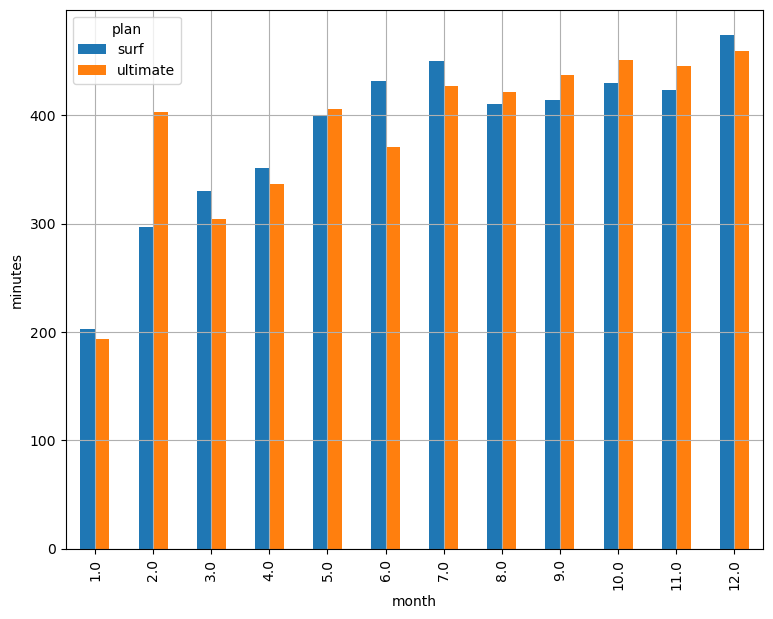

In [52]:
calls_plan.plot(kind='bar', grid=True, figsize=(9, 7))
plt.ylabel('minutes')

En 7 períodos el promedio de minutos utilizados por los usuarios del plan Ultimate supera a los del plan Surf. Sin embargo, salvo en el mes de Febrero, no es una diferencia considerable. Además, en ninguno de los planes este promedio supera los 500 minutos.

A continuación se filtrará el DataFrame por plan. Se estudiarán los minutos que requiere cada usuario por mes de cada plan y se mostrarán los histogramas correspondientes para una mejor visualización.

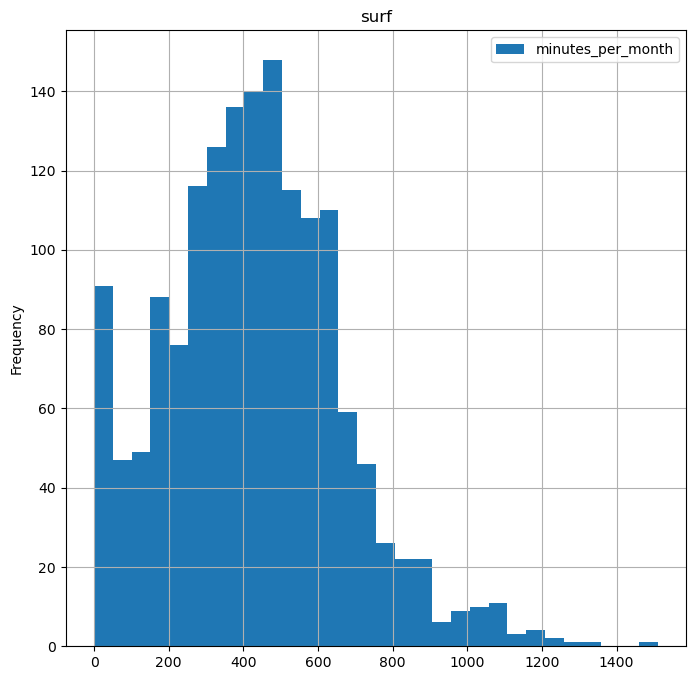

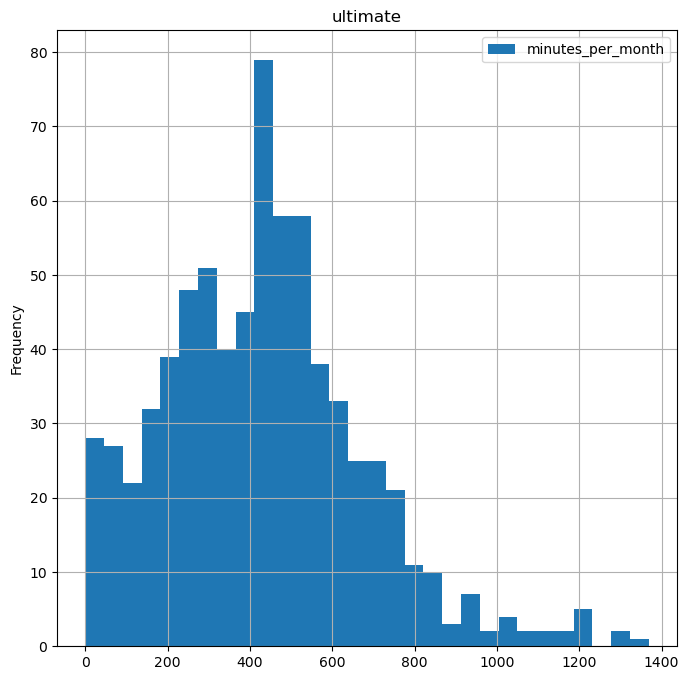

In [53]:
for name, group_data in df_users_periods.groupby('plan'):
    group_data.plot(kind='hist', y='minutes_per_month', bins=30, title=name, grid=True, figsize=(8, 8))

Como se observa, las distribuciones de los datos son similares. Se encontrará la media de cada plan y su desviación estándar para comparar sus dispersiones.

In [54]:
for name, group_data in df_users_periods.groupby('plan'):
    print(name)
    print(group_data['minutes_per_month'].describe())
    print()

surf
count    1573.000000
mean      428.749523
std       234.453150
min         0.000000
25%       272.000000
50%       425.000000
75%       576.000000
max      1510.000000
Name: minutes_per_month, dtype: float64

ultimate
count     720.000000
mean      430.450000
std       240.508762
min         0.000000
25%       260.000000
50%       424.000000
75%       565.250000
max      1369.000000
Name: minutes_per_month, dtype: float64



La diferencia entre la media y la desviación estándar del plan surf es 194.3, la cual es mayor que la del plan ultimate (189.94) pero no con una gran diferencia. Esto indica que los datos para ambos planes tienen una dispersión similar.

Los cuartiles del plan surf tienen valores mayores que los del plan ultimate. En el plan surf existen usuarios que necesitan 1510 minutos y en el plan ultimate existen usuarios que necesitan 1369 minutos.

Estas diferencias no son considerables, se mostrarán diagramas de caja para visualizar mejor estas similitudes.

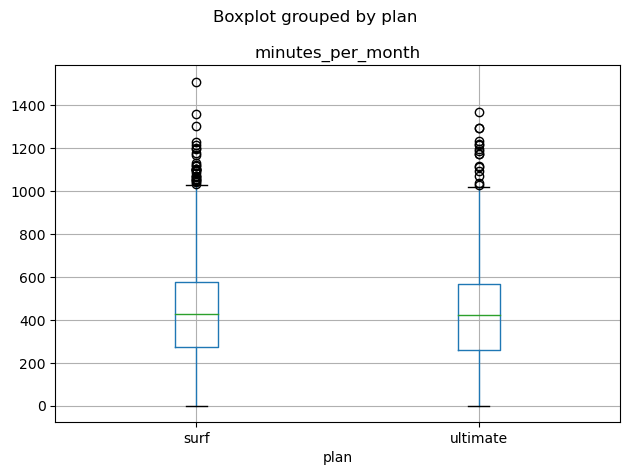

In [55]:
df_users_periods.boxplot(column='minutes_per_month', by='plan')
plt.tight_layout()

El comportamiento de los usuarios con respecto a los minutos utilizados por período es muy similar sin importar el plan. El promedio mensual para ambos planes no supera los 500 minutos. Sin embargo, el plan surf ofrece 500 minutos incluidos en el precio base, mientras que ultimate ofrece 3000 minutos. La cantidad máxima de minutos para el plan ultimate es 1369, lejos del límite de 3000. Por otro lado, más del 25% de usuarios del plan surf sobrepasan 500 minutos. Se concluye que el plan surf para llamadas le reditua más ingresos a Megaline por los cargos extra.

[Volver a Contenidos](#back)

### 3. 2. Mensajes <a id='data_analysis_messages'></a>

A partir del último DataFrame, se creará una tabla dinámica para mostrar el promedio de mensajes enviados por los usuarios de cada plan por mes. También se mostrará una gráfica de barras para comparar de mejor manera los datos.

In [56]:
messages_plan = df_users_periods.pivot_table(index='month', columns='plan', values='messages_per_month', aggfunc='mean')
print(messages_plan)

plan        surf   ultimate
month                      
1.0    10.500000  15.500000
2.0    12.000000  21.571429
3.0    15.260870  20.250000
4.0    17.400000  22.047619
5.0    24.012987  32.103448
6.0    25.298969  29.340426
7.0    27.033058  32.830508
8.0    28.777778  38.478873
9.0    30.762887  37.895349
10.0   33.839662  39.443396
11.0   32.385159  38.606299
12.0   38.600629  45.006623


Text(0, 0.5, 'messages')

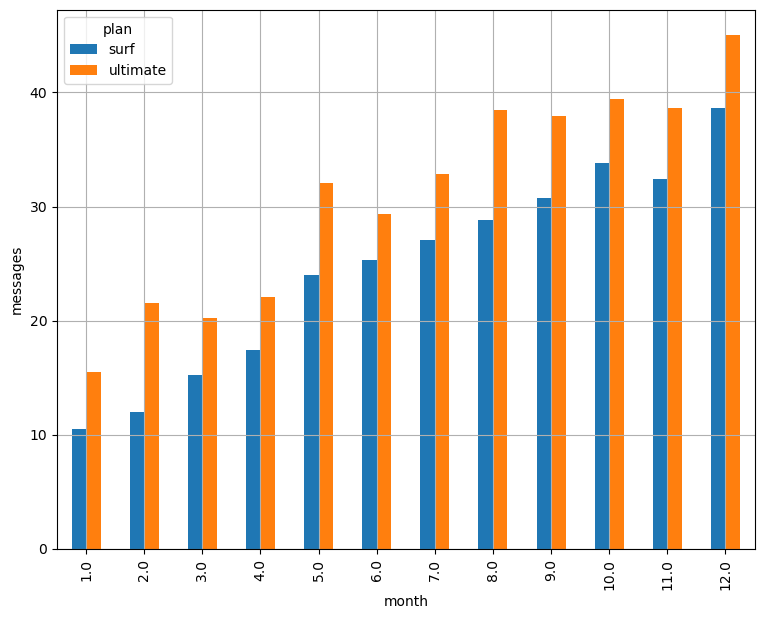

In [57]:
messages_plan.plot(kind='bar', grid=True, figsize=(9, 7))
plt.ylabel('messages')

El promedio de mensajes enviados por los usuarios del plan ultimate supera al de los usuarios del plan surf en todos los meses. Cabe destacar que dichos promedios, en ninguno de los dos planes, supera 50 mensajes. Se estudiarán los datos por plan.

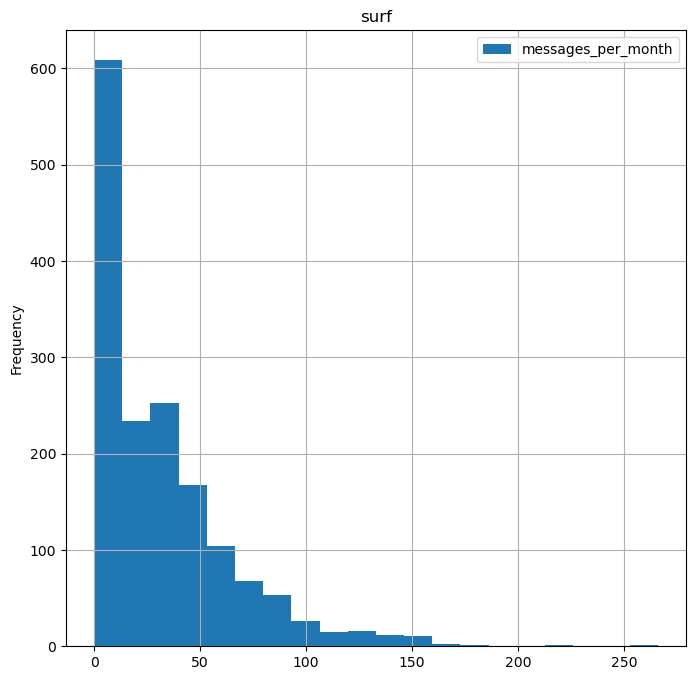

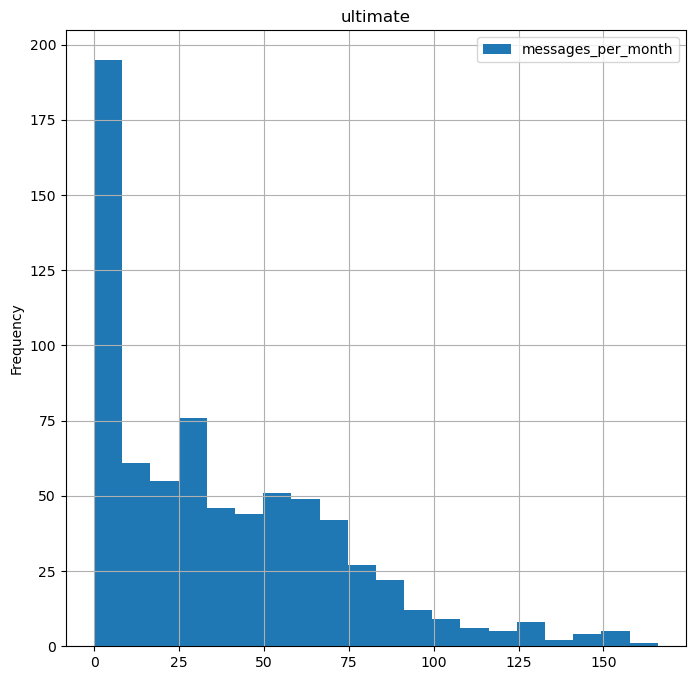

In [58]:
for name, group_data in df_users_periods.groupby('plan'):
    group_data.plot(kind='hist', y='messages_per_month', bins=20, title=name, grid=True, figsize=(8, 8))

En ambas distribuciones, la mayoría de datos está entre 0 y 50 mensajes enviados pero se observa que en el plan ultimate hay más usuarios que envían más de 50 mensajes. Se compararán las dispersiones de ambos planes.

In [59]:
for name, group_data in df_users_periods.groupby('plan'):
    print(name)
    print(group_data['messages_per_month'].describe())
    print()

surf
count    1573.000000
mean       31.159568
std        33.566717
min         0.000000
25%         3.000000
50%        24.000000
75%        47.000000
max       266.000000
Name: messages_per_month, dtype: float64

ultimate
count    720.000000
mean      37.551389
std       34.767179
min        0.000000
25%        7.000000
50%       30.000000
75%       61.000000
max      166.000000
Name: messages_per_month, dtype: float64



La media del plan surf es 31.15 mensajes enviados por mes, mientras que del plan ultimate es 37.5. La diferencia entre las medias y las desviaciones estándar son muy similares (ligeramente mayor en el plan ultimate).

Los valores de los cuartiles del plan ultimate son mayores que los del plan surf. En el plan surf, el 25% de usuarios envian más de 47 mensajes al mes con un máximo de 266, mientras que el 25% de los usuarios del plan ultimate envían más de 60 mensajes al mes, con un máximo de 166. Se mostrarán los diagramas de caja de ambos planes.

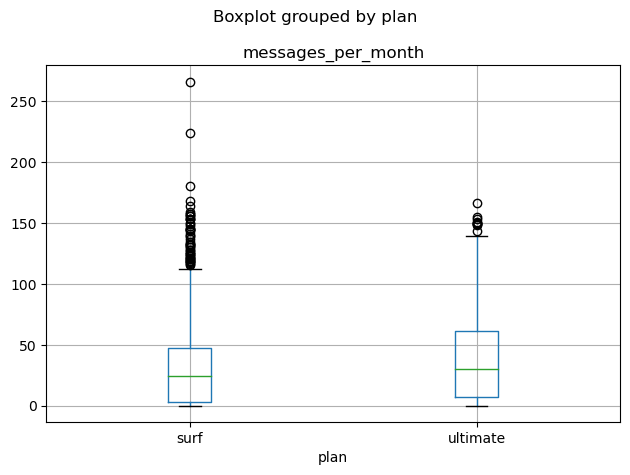

In [60]:
df_users_periods.boxplot(column='messages_per_month', by='plan')
plt.tight_layout()

Los usuarios del plan ultimate envían una mayor cantidad de mensajes al mes que los del plan surf. Aunque el promedio mensual para ambos planes no supera los 50 mensajes, por las características de los planes, el más rentable es el plan surf. Esto es porque el precio base del plan surf ofrece 50 mensajes incluidos, mientras que el plan ultimate ofrece 1000 mensajes, cifra muy lejana del máximo presentado que es 165. Así, el plan surf para mensajes le reditua más ingresos a Megaline por los cargos extra.

[Volver a Contenidos](#back)

### 3. 3. Internet <a id='data_analysis_mb'></a>

Como en las secciones anteriores, se creará una tabla dinámica para mostrar el promedio de megabytes utilizados por los usuarios de cada plan por mes. También se mostrará una gráfica de barras para comparar de mejor manera los datos.

In [61]:
internet_plan = df_users_periods.pivot_table(index='month', columns='plan', values='gb_per_month', aggfunc='mean')
print(internet_plan)

plan        surf   ultimate
month                      
1.0     5.000000   7.250000
2.0    12.222222  17.285714
3.0    13.565217  18.416667
4.0    12.220000  16.333333
5.0    14.116883  16.862069
6.0    15.484536  15.425532
7.0    16.876033  16.491525
8.0    16.882716  17.845070
9.0    16.690722  17.011628
10.0   17.409283  17.716981
11.0   16.431095  17.118110
12.0   18.238994  18.397351


Text(0, 0.5, 'gigabytes')

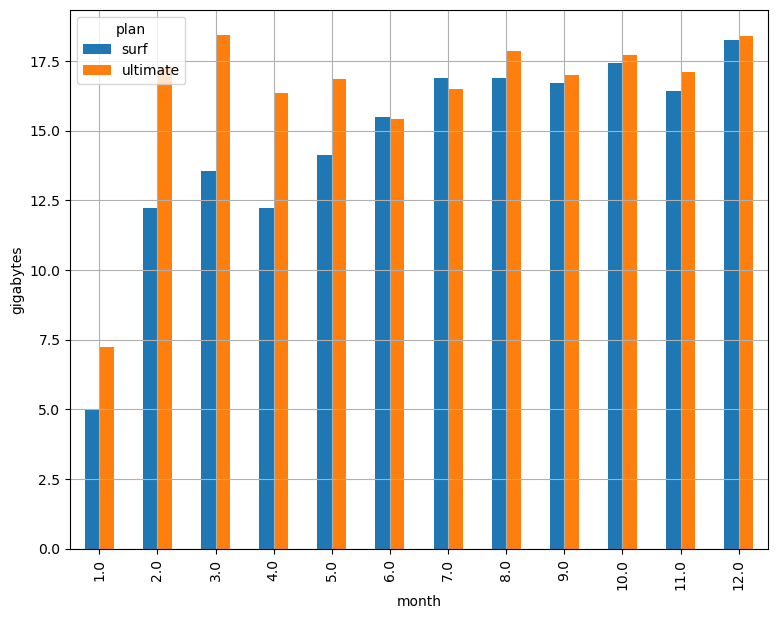

In [62]:
internet_plan.plot(kind='bar', grid=True, figsize=(9, 7))
plt.ylabel('gigabytes')

El promedio de megabytes utilizados por los usuarios del plan ultimate supera al de los usuarios del plan surf en 10 períodos. Cabe destacar que dichos promedios, en ninguno de los dos planes, supera 19 GB. Se estudiarán los datos por plan.

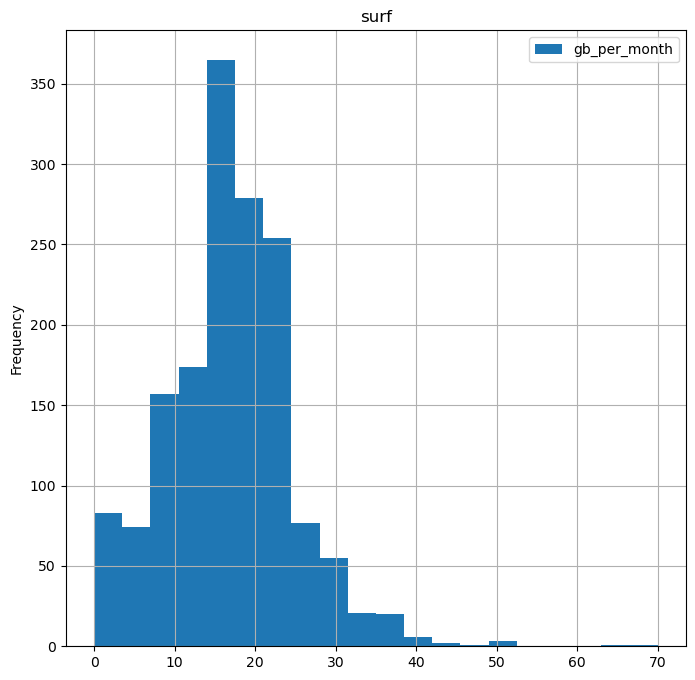

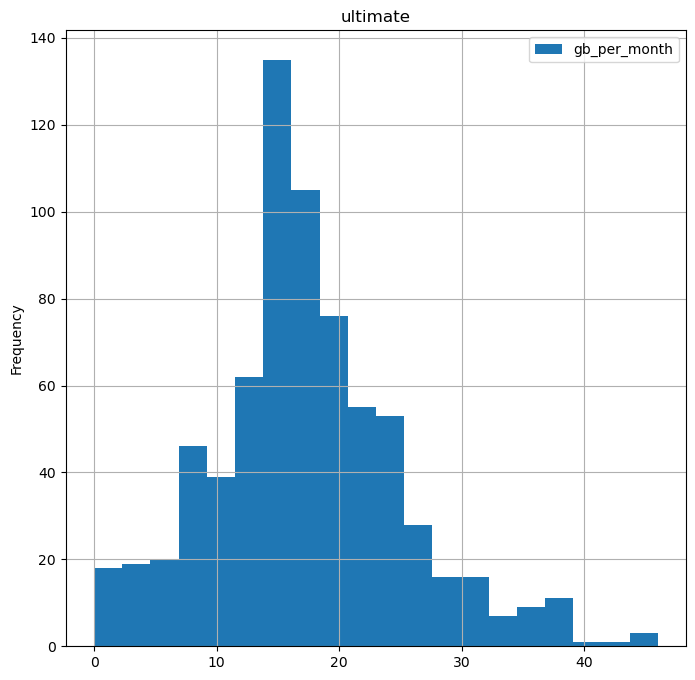

In [63]:
for name, group_data in df_users_periods.groupby('plan'):
    group_data.plot(kind='hist', y='gb_per_month', bins=20, title=name, grid=True, figsize=(8, 8))

En ambas distribuciones, la mayoría de datos está son menores a 30 gigabytes. Se compararán las dispersiones de ambos planes.

In [64]:
for name, group_data in df_users_periods.groupby('plan'):
    print(name)
    print(group_data['gb_per_month'].describe())
    print()

surf
count    1573.000000
mean       16.670693
std         7.847522
min         0.000000
25%        12.000000
50%        17.000000
75%        21.000000
max        70.000000
Name: gb_per_month, dtype: float64

ultimate
count    720.000000
mean      17.306944
std        7.670108
min        0.000000
25%       13.000000
50%       17.000000
75%       21.000000
max       46.000000
Name: gb_per_month, dtype: float64



La media del plan surf es 16.67 GB utilizados por mes, mientras que del plan ultimate es 17.30 GB. La diferencia entre las medias y las desviaciones estándar son muy similares, al igual que los valores de los cuartiles de ambos planes. En el plan surf, un 50% de usuarios utilizan más de 15 GB (limite de los megabytes incluidos en el precio base) con un máximo de 70 GB (más de 50 GB extras). Mientras que un 25% de los usuarios del plan ultimate utilizan más de 20 GB al mes, con un máximo de 46 GB (este plan incluye 30GB, por lo que serían 16 GB extras). Se mostrarán los diagramas de caja de ambos planes.

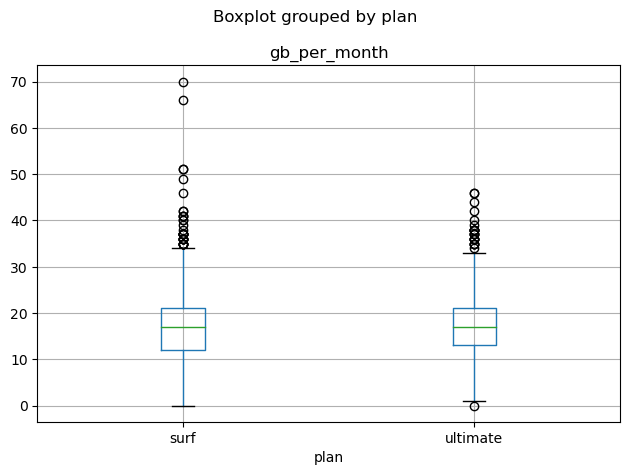

In [65]:
df_users_periods.boxplot(column='gb_per_month', by='plan')
plt.tight_layout()

El plan surf en cuanto a gigabytes utilizados es mucho más rentable para Megaline por los cargos extra, pues más del 50% de los usuarios sobrepasan el límite de los gigabytes incluidos en el precio base.

[Volver a Contenidos](#back)

### 3. 4. Ingreso <a id='data_analysis_income'></a>

Finalmente, se creará una tabla dinámica para mostrar el promedio del pago mensual realizado por los usuarios de cada plan. También se mostrará una gráfica de barras para comparar de mejor manera los datos.

In [66]:
pay_plan = df_users_periods.pivot_table(index='month', columns='plan', values='period_pay', aggfunc='mean')
print(pay_plan)

plan        surf   ultimate
month                      
1.0    20.000000  70.000000
2.0    34.396667  70.000000
3.0    45.941304  74.666667
4.0    40.710600  73.000000
5.0    47.628182  70.724138
6.0    49.276289  71.638298
7.0    62.674050  71.898305
8.0    63.931173  72.859155
9.0    58.271495  72.034884
10.0   65.421224  72.311321
11.0   58.004276  71.708661
12.0   70.557044  73.291391


Text(0, 0.5, 'USD')

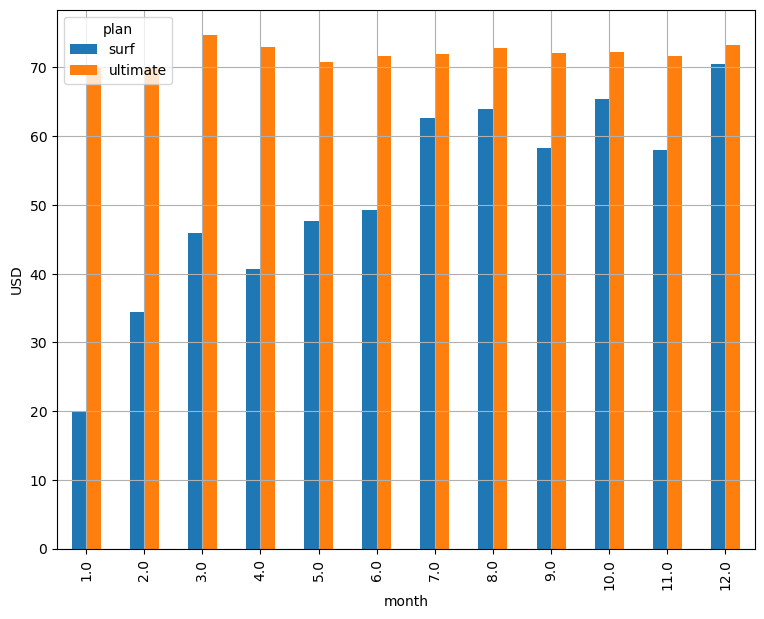

In [67]:
pay_plan.plot(kind='bar', grid=True, figsize=(9, 7))
plt.ylabel('USD')

El promedio del ingreso mensual de los usuarios del plan ultimate supera al de los usuarios del plan surf en todos los períodos. Cabe destacar que dichos promedios, no superan con gran diferencia el precio base del plan que es 70 USD, mientras que en el plan surf, todos los promedios (salvo el del primer período) superan el precio base que es de 20 USD por más de 10 USD. Se estudiarán los datos por plan.

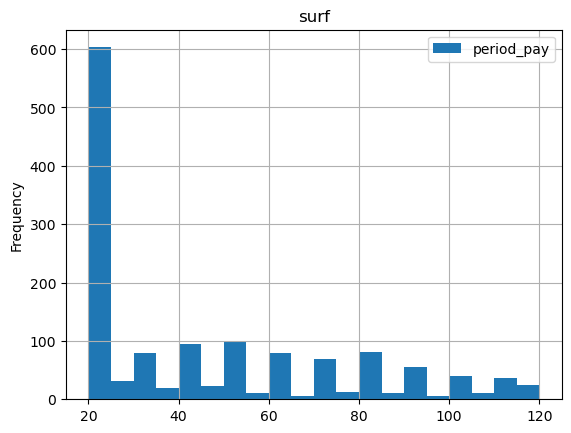

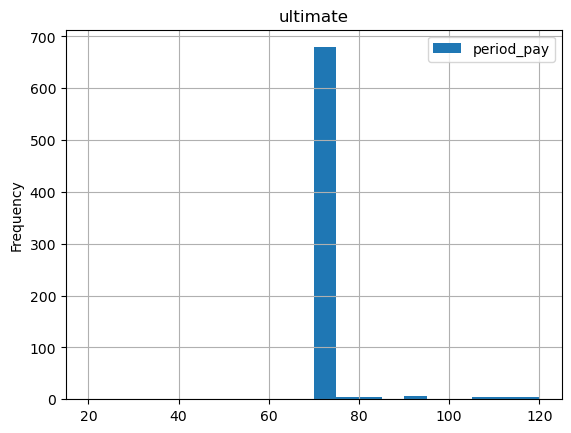

In [68]:
for name, group_data in df_users_periods.groupby('plan'):
    group_data.plot(kind='hist', y='period_pay', bins=20, title=name, grid=True, range=(20, 120))

Se observa que la mayoría de los usuarios del plan ultimate pagan menos de 80 USD al mes, mientras que la mayoría de usuarios del plan surf pagan menos de 40 USD al mes. Se mostrarán las estadísiticas descriptivas de ambos planes para un mejor análisis.

In [69]:
for name, group_data in df_users_periods.groupby('plan'):
    print(name)
    print(group_data['period_pay'].describe())
    print()

surf
count    1573.000000
mean       60.706408
std        55.388042
min        20.000000
25%        20.000000
50%        40.360000
75%        80.360000
max       590.370000
Name: period_pay, dtype: float64

ultimate
count    720.000000
mean      72.313889
std       11.395108
min       70.000000
25%       70.000000
50%       70.000000
75%       70.000000
max      182.000000
Name: period_pay, dtype: float64



La media del plan surf es 60 USD y la diferencia con la desviación estándar es de 5.32, lo que indica que los datos no están muy dispersos. El 50% de los usuarios de este plan pagan más de 40 USD al mes, alcanzando un máximo de 590.37 USD.

La media del plan ultimate es 72.31 USD y la diferencia con la desviación estándar es de 60.92, lo que indica que hay datos muy dispersos. El 75% de los usuarios paga mensualmente el precio base del plan (70 USD). El otro 25% puede alcanzar hasta un máximo de 182 USD.

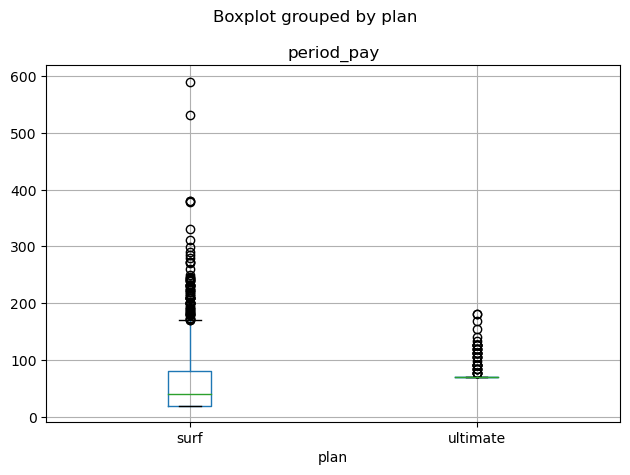

In [70]:
df_users_periods.boxplot(column='period_pay', by='plan')
plt.tight_layout()

Se observa como difieren los diagramas de caja. Se mostrará una tabla con el total de los ingresos de los usuarios por período de cada plan.

In [71]:
df_pay_plan = df_users_periods.pivot_table(index='month', columns='plan', values='period_pay', aggfunc='sum', margins=True)
print(df_pay_plan)

plan       surf  ultimate        All
month                               
1.0       40.00     280.0     320.00
2.0      309.57     490.0     799.57
3.0     1056.65     896.0    1952.65
4.0     2035.53    1533.0    3568.53
5.0     3667.37    2051.0    5718.37
6.0     4779.80    3367.0    8146.80
7.0     7583.56    4242.0   11825.56
8.0    10356.85    5173.0   15529.85
9.0    11304.67    6195.0   17499.67
10.0   15504.83    7665.0   23169.83
11.0   16415.21    9107.0   25522.21
12.0   22437.14   11067.0   33504.14
All    95491.18   52066.0  147557.18


Se observa que en la lamayoría de los meses, los ingresos de los usuarios del plan surf son mucho mayores que los del plan ultimate, casi el doble.

[Volver a Contenidos](#back)

### 3. 5. Conclusiones <a id='data_analysis_conclusions'></a>

Se comparó el comportamiento de los usuarios de cada plan en cada uno de los servicios ofrecidos (minutos, mensajes y gigabytes) por mes y se mostraron gráficas correspondientes para visualizar de mejor manera estas comparaciones.

El comportamiento para los tres servicios es muy similar. Por esta razón, el plan surf es más rentable para Megaline pues el precio base (20 USD) incluye una mucho menor cantidad de minutos (500), mensajes (50) y gigabytes (15 GB) por mes y las tarifas por servicio extra son más altas que en el plan ultimate. Por esta razón, más de la mitad de los usuarios de este plan pagan más de los 20 USD al mes.

[Volver a Contenidos](#back)

## Etapa 4. Comprobación de hipótesis <a id='data_hypothesis'></a>

Se plantearon las siguientes hipótesis:

1. El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.
2. El ingreso promedio de los usuarios en el área de estados Nueva York - Nueva Jersey es diferente al de los usuarios de otras regiones.

En esta etapa se harán pruebas de hipótesis para comprobarlas.

### 4. 1. El ingreso difiere por plan <a id='data_hypothesis_plan'></a>

Para verificar la primera hipótesis, se estable como hipótesis nula la siguiente:

**H0: El ingreso promedio de los usuarios de las tarifas Ultimate es igual al de las tarifas Surf.**

Por lo que la hipótesis alternativa es:

**H1: El ingreso promedio de los usuarios de las tarifas Ultimate no es igual al de las tarifas Surf.**

Se utilizará la prueba-t con un nivel de significancia estadística del 5%.

Se filtrará la tabla por plan y se crearán tablas con los promedios de los ingresos mensuales por usuario.

In [72]:
plan = {}
for name in ['surf', 'ultimate']:
    plan[name] = df_users_periods.query('plan == @name')

In [73]:
plan_pay = {}
for name in ['surf', 'ultimate']:
    plan_pay[name] = plan[name].pivot_table(index='user_id', values='period_pay')

print(plan_pay['surf'].head())
print()
print(plan_pay['ultimate'].head())

         period_pay
user_id            
1001      50.018000
1002      33.333333
1003     158.120000
1004      76.250000
1005      40.000000

         period_pay
user_id            
1000           70.0
1006           77.0
1008           70.0
1011           70.0
1013           70.0


Con estas dos tablas se verificará la hipótesis.

In [74]:
alpha = 0.05 #nivel de significancia

results_pay = st.ttest_ind(plan_pay['surf'], plan_pay['ultimate'], equal_var=False)

print('p-value:', results_pay.pvalue)

if results_pay.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value: [5.71943513e-08]
Rechazamos la hipótesis nula


Se rechaza la hipótesis nula. Es decir, se concluye que el ingreso promedio de los usuarios difiere según el plan adquirido.

Se hará una prueba de hipótesis similar para la siguiente hipótesis planteada.

[Volver a Contenidos](#back)

### 4. 2. El ingreso difiere por región <a id='data_hypothesis_zone'></a>

Para verificar la segunda hipótesis, se establece como hipótesis nula la siguiente:

**H0: El ingreso promedio de los usuarios del área NY-NJ es igual al de los usuarios de las otras áreas.**

Por lo que la hipótesis alternativa es:

**H1: El ingreso promedio de los usuarios del área NY-NJ no es igual al de los usuarios de las otras áreas.**

Se utilizará la prueba-t con un nivel de significancia estadística del 5%.

Se filtrará la tabla por el área NY-NJ y se crearán tablas con los promedios de los ingresos por usuario. Para comenzar, se mostrarán los valores de la columna `'city'`.

In [75]:
print(df_users_periods['city'].sort_values().unique())

['Albany-Schenectady-Troy, NY MSA' 'Albuquerque, NM MSA'
 'Atlanta-Sandy Springs-Roswell, GA MSA'
 'Austin-Round Rock-Georgetown, TX MSA' 'Bakersfield, CA MSA'
 'Baltimore-Columbia-Towson, MD MSA' 'Baton Rouge, LA MSA'
 'Birmingham-Hoover, AL MSA' 'Boston-Cambridge-Newton, MA-NH MSA'
 'Bridgeport-Stamford-Norwalk, CT MSA' 'Buffalo-Cheektowaga, NY MSA'
 'Cape Coral-Fort Myers, FL MSA' 'Charleston-North Charleston, SC MSA'
 'Charlotte-Concord-Gastonia, NC-SC MSA'
 'Chicago-Naperville-Elgin, IL-IN-WI MSA' 'Cincinnati, OH-KY-IN MSA'
 'Cleveland-Elyria, OH MSA' 'Colorado Springs, CO MSA' 'Columbia, SC MSA'
 'Columbus, OH MSA' 'Dallas-Fort Worth-Arlington, TX MSA'
 'Dayton-Kettering, OH MSA' 'Denver-Aurora-Lakewood, CO MSA'
 'Detroit-Warren-Dearborn, MI MSA' 'El Paso, TX MSA' 'Fresno, CA MSA'
 'Grand Rapids-Kentwood, MI MSA' 'Greensboro-High Point, NC MSA'
 'Houston-The Woodlands-Sugar Land, TX MSA'
 'Indianapolis-Carmel-Anderson, IN MSA' 'Jacksonville, FL MSA'
 'Kansas City, MO-KS MSA' 'Kno

Se crean las tablas filtradas por `'New York-Newark-Jersey City, NY-NJ-PA MSA'`.

In [76]:
ny_nj = 'New York-Newark-Jersey City, NY-NJ-PA MSA'
city_ny_nj = df_users_periods.query('city == @ny_nj')
city_other = df_users_periods.query('city != @ny_nj')

pay_ny_nj = city_ny_nj.pivot_table(index='user_id', values='period_pay')
pay_other_city = city_other.pivot_table(index='user_id', values='period_pay')

print(pay_ny_nj.head())
print()
print(pay_other_city.head())

         period_pay
user_id            
1014      29.420000
1022      56.125000
1024      21.920000
1027      33.333333
1031      70.000000

         period_pay
user_id            
1000      70.000000
1001      50.018000
1002      33.333333
1003     158.120000
1004      76.250000


Con estas dos tablas se verificará la hipótesis.

In [77]:
results_pay_city = st.ttest_ind(pay_ny_nj, pay_other_city, equal_var=False)

print('p-value:', results_pay_city.pvalue)

if results_pay_city.pvalue < alpha:
    print("Rechazamos la hipótesis nula")
else:
    print("No rechazamos la hipótesis nula")

p-value: [0.44104821]
No rechazamos la hipótesis nula


Con los resultados de esta prueba, no se puede concluir que el ingreso mensual de los usuarios de NY-NJ sea distinto al de otras áreas.

## Etapa 5. Conclusión general <a id='data_conclusion'></a>

En este estudio se analizaron los datos de tarifas de clientes de Megaline, el cual ofrece dos planes tarifarios. Uno de los objetivos fue determinar cual de los planes genera más ingresos. De este modo, se estudió el promedio de minutos, mensajes y gigabytes utilizados por mes de los usuarios de cada plan. Se concluyó que el comportamiento de utilización de estos servicios es similar, sin embargo, el precio base de uno de los planes es mucho más limitado lo que implica cargos extra para los usuarios de este plan. En este sentido, el plan Surf ha generado más ingresos para Megaline.

La primera hipótesis planteada fue:
1. El ingreso promedio de los usuarios de las tarifas Ultimate y Surf difiere.

Para veririficar esta hipótesis se hizo una prueba-t con un nivel de significancia del 5%, con lo que se concluyó que este promedio si difiere. De hecho, con los datos se verificó que los usuarios del plan surf generan más ingresos para Megaline.

La segunda hipótesis fue:

2. El ingreso promedio de los usuarios en el área de estados Nueva York - Nueva Jersey es diferente al de los usuarios de otras regiones.

De la misma manera que con la primera hipótesis, para verificarla se utilizo una prueba-t con nivel de significancia del 5%. El resultado obtenido es que no se puede rechazar que el ingreso promedio de los usuarios del área de Nueva York - Nueva Jersey es igual al de los usuarios de otras áreas. Así, no se puede concluir que esta hipótesis es verdadera.

[Volver a Contenidos](#back)